<a href="https://colab.research.google.com/github/subhramit/unet_segmentation/blob/main/unet_seg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import tensorflow_datasets as tfds
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete504Q8K/oxford_iiit_pet-train.tfrecord


  0%|          | 0/3680 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete504Q8K/oxford_iiit_pet-test.tfrecord


  0%|          | 0/3669 [00:00<?, ? examples/s]

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [4]:
def resize(input_image, input_mask):
   input_image = tf.image.resize(input_image,(128, 128),method="nearest")
   input_mask = tf.image.resize(input_mask,(128, 128),method="nearest")

   return input_image, input_mask

In [5]:
def augment(input_image, input_mask):
   if tf.random.uniform(())>0.5:
       # Random flipping of the image and mask
       input_image = tf.image.flip_left_right(input_image)
       input_mask = tf.image.flip_left_right(input_mask)

   return input_image, input_mask

In [6]:
def normalize(input_image, input_mask):
   input_image = tf.cast(input_image, tf.float32)/255.0
   input_mask -= 1
   return input_image, input_mask

In [7]:
def load_image_train(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image,input_mask)
   input_image, input_mask = augment(input_image,input_mask)
   input_image, input_mask = normalize(input_image,input_mask)

   return input_image, input_mask

def load_image_test(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image,input_mask)
   input_image, input_mask = normalize(input_image,input_mask)

   return input_image, input_mask

In [8]:
train_dataset = dataset["train"].map(load_image_train,num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(load_image_test,num_parallel_calls=tf.data.AUTOTUNE)

In [9]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

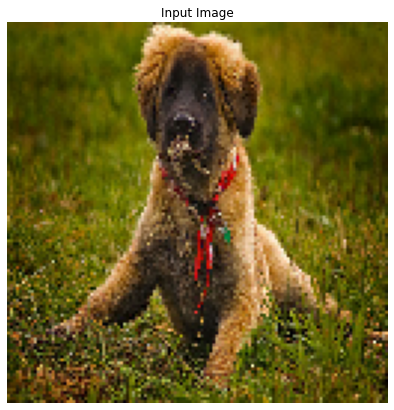

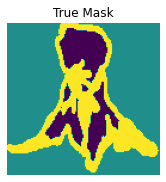

In [19]:
def display(display_list):
 plt.figure(figsize=(15,15))

 title = ["Input Image", "True Mask", "Predicted Mask"]

 for i in range(len(display_list)):
   plt.subplot(1,len(display_list),i+1)
   plt.title(title[i])
   plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
   plt.axis("off")
   plt.show()

sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index],sample_batch[1][random_index]
display([sample_image, sample_mask])

In [20]:
def double_conv_block(x, n_filters):

   # Conv2D then ReLU activation
   x = tf.keras.layers.Conv2D(n_filters,3,padding = "same",activation = "relu",kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = tf.keras.layers.Conv2D(n_filters,3,padding = "same",activation = "relu",kernel_initializer = "he_normal")(x)

   return x

In [21]:
def downsample_block(x,n_filters):
   f = double_conv_block(x,n_filters)
   p = tf.keras.layers.MaxPool2D(2)(f)
   p = tf.keras.layers.Dropout(0.3)(p)

   return f, p

In [22]:
def upsample_block(x,conv_features,n_filters):
   # upsample
   x = tf.keras.layers.Conv2DTranspose(n_filters,3,2,padding="same")(x)
   # concatenate
   x = tf.keras.layers.concatenate([x,conv_features])
   # dropout
   x = tf.keras.layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x,n_filters)

   return x

In [23]:
def build_unet_model():

    # inputs
    inputs = tf.keras.layers.Input(shape=(128,128,3))

    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs,64)
    # 2 - downsample
    f2, p2 = downsample_block(p1,128)
    # 3 - downsample
    f3, p3 = downsample_block(p2,256)
    # 4 - downsample
    f4, p4 = downsample_block(p3,512)

    # 5 - bottleneck
    bottleneck = double_conv_block(p4,1024)

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck,f4,512)
    # 7 - upsample
    u7 = upsample_block(u6,f3,256)
    # 8 - upsample
    u8 = upsample_block(u7,f2,128)
    # 9 - upsample
    u9 = upsample_block(u8,f1,64)

    # outputs
    outputs = tf.keras.layers.Conv2D(3,1,padding="same",activation = "softmax")(u9)

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

In [24]:
unet_model = build_unet_model()

In [25]:
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [26]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),loss="sparse_categorical_crossentropy",metrics="accuracy")

In [27]:
EPOCHS = 10

TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH//BATCH_SIZE

VAL_SUBSPLITS = 5
TEST_LENTH = info.splits["test"].num_examples
VALIDATION_STEPS = TEST_LENTH//BATCH_SIZE//VAL_SUBSPLITS

model_history = unet_model.fit(train_batches,epochs=EPOCHS,steps_per_epoch=STEPS_PER_EPOCH,validation_steps=VALIDATION_STEPS,validation_data=validation_batches)

Epoch 1/10
57/57 [==============================] - 79s 931ms/step - loss: 0.8403 - accuracy: 0.6397 - val_loss: 0.6975 - val_accuracy: 0.7149
Epoch 2/10
57/57 [==============================] - 61s 950ms/step - loss: 0.6410 - accuracy: 0.7423 - val_loss: 0.6742 - val_accuracy: 0.7432
Epoch 3/10
57/57 [==============================] - 55s 962ms/step - loss: 0.5667 - accuracy: 0.7757 - val_loss: 0.5248 - val_accuracy: 0.7941
Epoch 4/10
57/57 [==============================] - 55s 968ms/step - loss: 0.5254 - accuracy: 0.7936 - val_loss: 0.4943 - val_accuracy: 0.8042
Epoch 5/10
57/57 [==============================] - 55s 969ms/step - loss: 0.4691 - accuracy: 0.8183 - val_loss: 0.4359 - val_accuracy: 0.8302
Epoch 6/10
57/57 [==============================] - 55s 969ms/step - loss: 0.4257 - accuracy: 0.8357 - val_loss: 0.4076 - val_accuracy: 0.8449
Epoch 7/10
57/57 [==============================] - 55s 970ms/step - loss: 0.4118 - accuracy: 0.8413 - val_loss: 0.4120 - val_accuracy: 0.8382

In [28]:
def display_learning_curves(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs_range = range(EPOCHS)

    fig = plt.figure(figsize=(12,6))

    plt.subplot(1,2,1)
    plt.plot(epochs_range, acc, label="train accuracy")
    plt.plot(epochs_range, val_acc, label="validataion accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")

    plt.subplot(1,2,2)
    plt.plot(epochs_range, loss, label="train loss")
    plt.plot(epochs_range, val_loss, label="validataion loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")

    fig.tight_layout()
    plt.show()

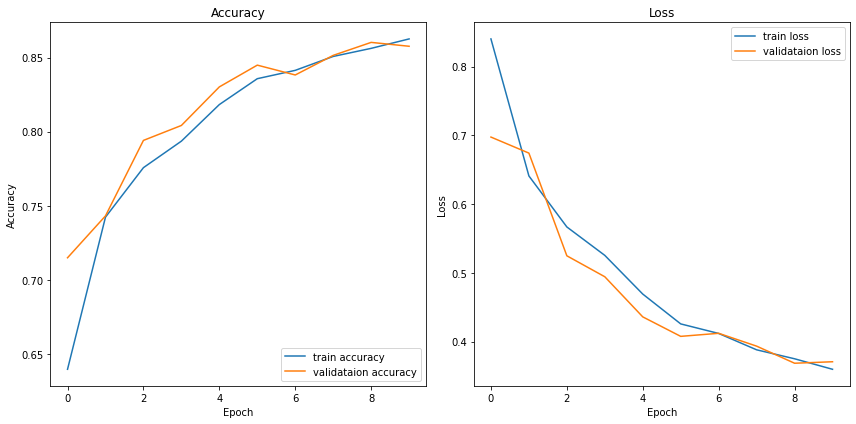

In [29]:
display_learning_curves(unet_model.history)

In [30]:
def create_mask(pred_mask):
 pred_mask = tf.argmax(pred_mask, axis=-1)
 pred_mask = pred_mask[..., tf.newaxis]
 return pred_mask[0]

def show_predictions(dataset=None, num=1):
 if dataset:
   for image, mask in dataset.take(num):
     pred_mask = unet_model.predict(image)
     display([image[0], mask[0], create_mask(pred_mask)])
 else:
   display([sample_image, sample_mask,
            create_mask(model.predict(sample_image[tf.newaxis, ...]))])

count = 0
for i in test_batches:
   count +=1
print("number of batches:", count)

number of batches: 11


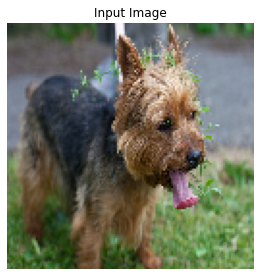

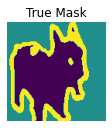

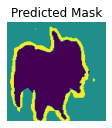

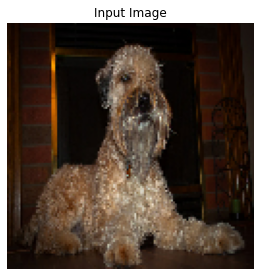

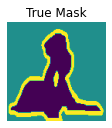

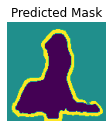

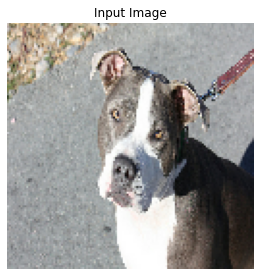

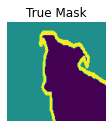

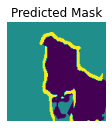

In [31]:
show_predictions(test_batches.skip(5),3)